# Replication: Autoencoder asset pricing model
---

[Autoencoder asset pricing model](#https://www.sciencedirect.com/science/article/abs/pii/S0304407620301998) replication 및 pdp 확인

**Backgrounds**
- 자산가격결정모형에서 [FF3](#https://www.sciencedirect.com/science/article/abs/pii/0304405X93900235) 이후 자산가격에 영향을 미치는 많은 요인들이 제시되어옴
- 하찮게 느껴질정도로 너무 많이 제시됨
- [Cochrane, 2011](#https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.2011.01671.x) 연설에서 factor zoo로부터 중요한 요인을 추려내야할 필요성 제기
- 이후 dimension reduction 방법론이 많이 연구됨(PCA, [IPCA](#https://www.sciencedirect.com/science/article/abs/pii/S0304405X19301151), ...)
- 위 논문은 auto-encoder의 아이디어에 착안하여 94개 요인에 대한 dimension reduction을 수행하는 자산가격결정모델 개발


**Model and data**

- train: 2001~ / valid: 2007~ / test: 2011~2020 (3:2:5), frequency: monthly
- features
    - scale: cross-sectionally normalized
    - beta: 94개 주식특성을 6개 latent factor loading로 encoding
    - factor: 94개 주식특성으로 구성된 94개 longshort pf 수익률로부터 6개 latent 수익률로 encoding
    - pred = sum(beta * factor)
- label
    - curr return: 미래 수익률이 아닌 현재 수익률 예측(많은 금융연구가 그러하듯 현시점 자산가격과 현시점 자산특성간 관계를 밝히는 목적)

<img src="cae.png"/>

**PDPs: univariate**

In [1]:
import os

import mlflow.pytorch
from mlflow import MlflowClient
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from gkx_nn.data import GKXDatasetFactory, normalize

# model
client = MlflowClient()
run = client.search_runs("0")[0]
model_uri = os.path.join(run.info.artifact_uri, "model")
model = mlflow.pytorch.load_model(model_uri).eval()

In [2]:
# pdp
def pdp(xnm):
    char_cols = GKXDatasetFactory("../data").char_cols
    steps = 100
    chars = torch.zeros(steps, len(char_cols))
    xs = torch.linspace(-1, 1, steps)
    char_idx = char_cols.index(xnm)
    chars[:, char_idx] = xs
    pfr_seq = torch.zeros_like(chars)
    preds = [
        model(char.unsqueeze(0), pfr.unsqueeze(0)).item() for char, pfr in zip(chars, pfr_seq)
    ]
    plt.plot(xs, preds)
    plt.xlabel(xnm)
    plt.ylabel("pred")

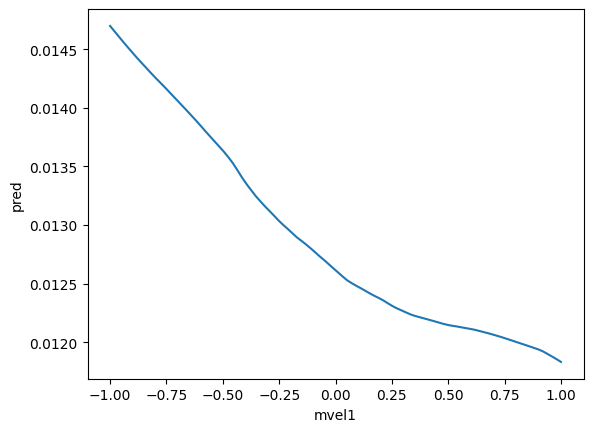

In [3]:
pdp("mvel1") # 규모 (market capitalization)

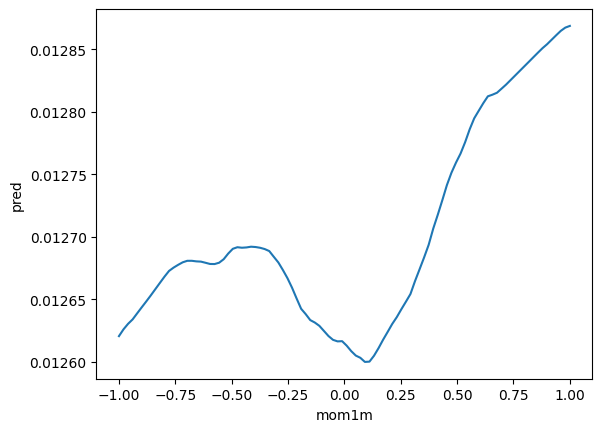

In [4]:
pdp("mom1m") # 최근 1개월 수익률 (short-term momentum)

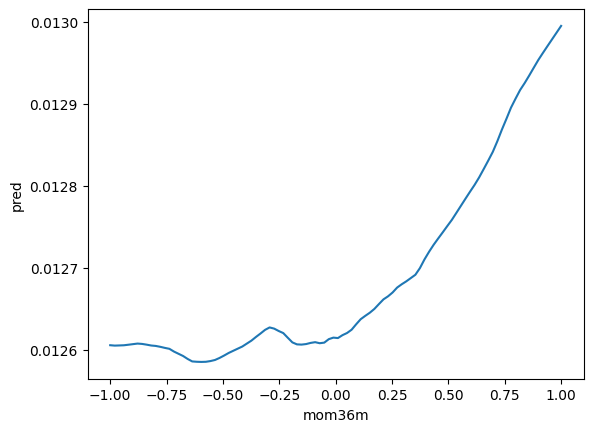

In [5]:
pdp("mom36m") # 최근 36개월 수익률 (long-term momentum)

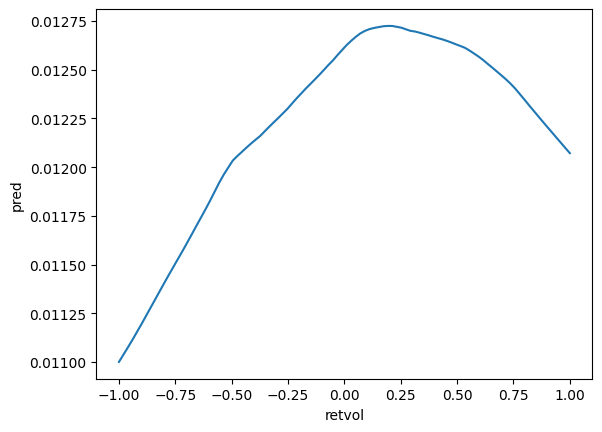

In [6]:
pdp("retvol") # 가격 변동성

**PDPs: bivariate**

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm

def bivariate_pdp(x0nm, x1nm, steps=16):
    char_cols = GKXDatasetFactory("../data").char_cols
    x0loc = char_cols.index(x0nm)
    x1loc = char_cols.index(x1nm)
    x0s = torch.linspace(-1, 1, steps)
    x1s = torch.linspace(-1, 1, steps)
    grids = torch.meshgrid(x0s, x1s, indexing="xy")
    preds = []
    for x0, x1 in zip(*grids):
        chars = torch.zeros(steps, len(char_cols))
        chars[:, x0loc] = x0
        chars[:, x1loc] = x1
        pfrs = torch.zeros_like(chars)
        preds.append(model(chars, pfrs))

    x, y = grids
    x, y = x.detach().numpy(), y.detach().numpy()
    z = torch.stack(preds)
    z = z.detach().numpy()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z, edgecolor="grey", color="grey", alpha=.3, lw=.5)

    # ax.contour(x, y, z, zdir='z', offset=z.min(), cmap='coolwarm')
    ax.contour(x, y, z, zdir='x', offset=x.min(), cmap='coolwarm')
    ax.contour(x, y, z, zdir='y', offset=y.max(), cmap='coolwarm')
    ax.set(xlabel=x0nm, ylabel=x1nm, zlabel='pred')
    plt.show()

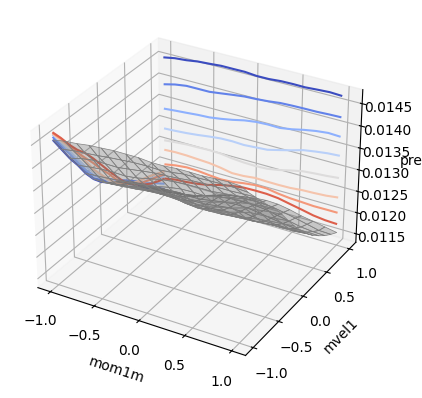

In [8]:
bivariate_pdp("mom1m", "mvel1") # 최근 1개월 수익률, 규모

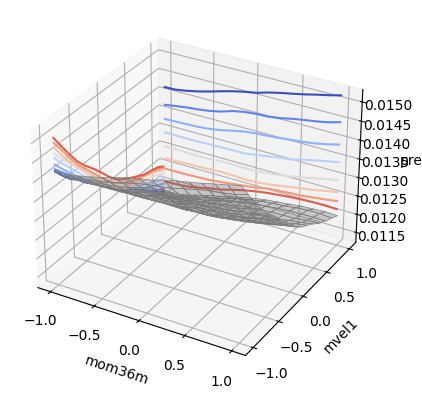

In [9]:
bivariate_pdp("mom36m", "mvel1") # 최근 36개월 수익률, 규모

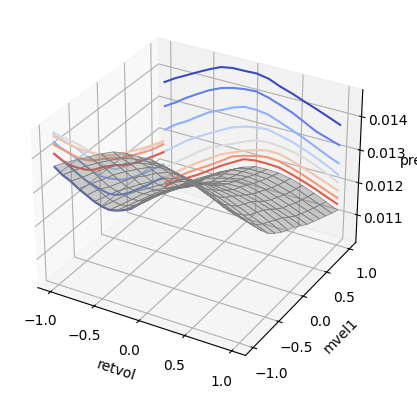

In [10]:
bivariate_pdp("retvol", "mvel1") # 가격 변동성, 규모

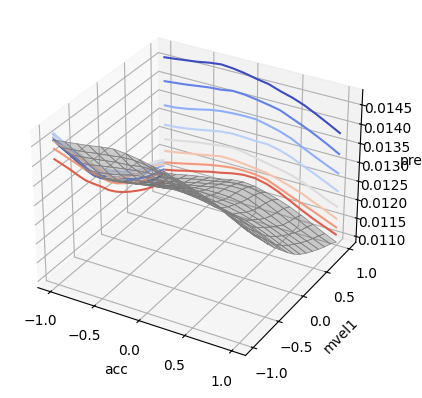

In [11]:
bivariate_pdp("acc", "mvel1") # accruals, 규모

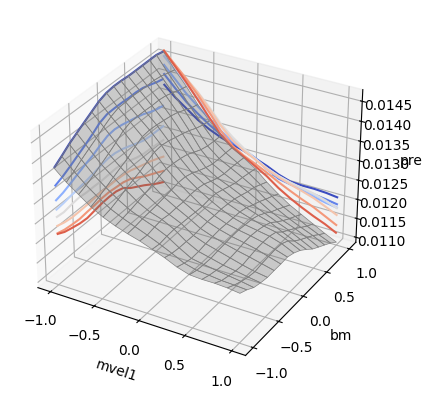

In [12]:
bivariate_pdp("mvel1", "bm") # 규모, book-to-market ratio(낮을수록 성장주, 높을수록 가치주)

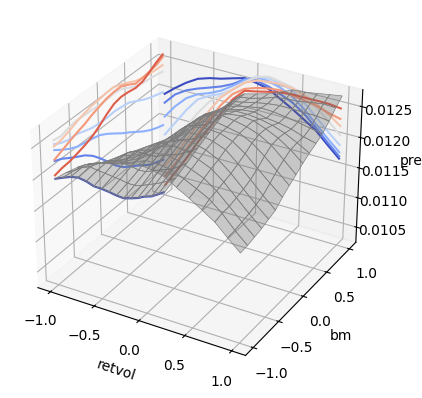

In [13]:
bivariate_pdp("retvol", "bm") # 변동성, b-t-m

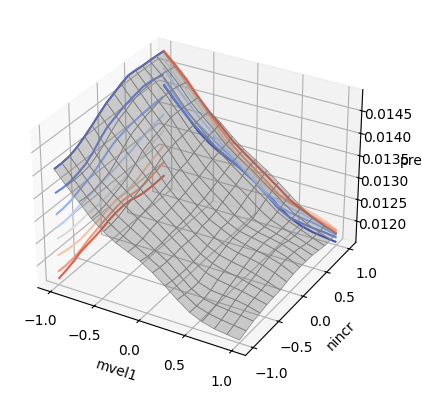

In [14]:
bivariate_pdp("mvel1", "nincr") # 규모, (아마도)새로 상장된 주식 수

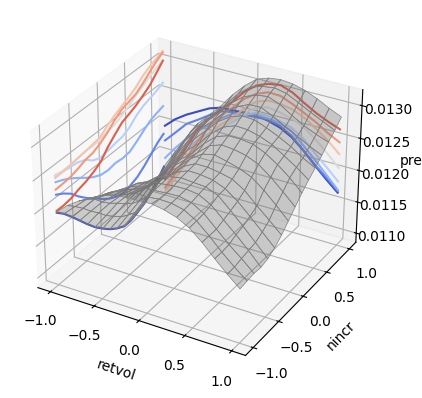

In [15]:
bivariate_pdp("retvol", "nincr") # 변동성, (아마도)새로 상장된 주식 수

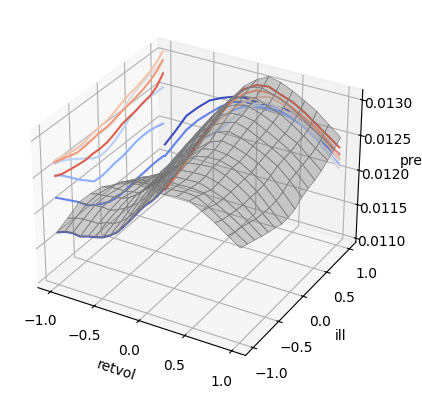

In [16]:
bivariate_pdp("retvol", "ill") # 변동성, 비유동성